In [0]:
# Code below allows google collab to detect dataset (requires id from shareable link)
# I got the code from here: https://stackoverflow.com/questions/50625320/how-to-access-files-on-google-drive-via-google-colab-notebook-ipynb
# But I am not really sure how it works, I am new to google collab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate google collab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Load data for authentication

# Batch1
file_id = '1BZThzsBCn4tUvx3hQs5ucqfk6bgAsdtk'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1BZThzsBCn4tUvx3hQs5ucqfk6bgAsdtk'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Batch1.png') 

# Batch2
file_id = '1z7hY1AfLvCC0gojzQcMPDAlE9xK4dp9k'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1z7hY1AfLvCC0gojzQcMPDAlE9xK4dp9k'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Batch2.png') 

## Generating The Data Set

Let us setup an $3 \times 2$ factorial design with one contextual variable.

$$Y = \beta_{0} + \beta_{1}Charity2 + \beta_{2}Charity3 + \beta_{3}Matching + \beta_{4}Republican + \beta_{5}Matching \times Charity2 + \beta_{6}Matching \times Charity3 + \beta_{7}Matching \times Republican + \epsilon $$

In the simulation we set
$\beta_{0} = 40, \beta_{1} = 10, \beta_{2} = 20, \beta_{3} = 15, \beta_{4} = -10, \beta_{5} = -5, \beta_{6} = 5,$ and  $\beta_{7} = -5.$  Note that Matching, charity, and republican are all binary variables taking on 0 or 1. This is the true reward function.

In [0]:
# Load python libraries
import pandas as pd
import numpy.random as nprnd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from scipy.stats import invgamma


## Adjust code below to generate the data
# Data setup
samplesize = 1000
numcharities = 3

# Contextual variable (binary)
rep_participant = nprnd.randint(2, size = samplesize)

## Experimental variables
# Binary matching
matching = nprnd.randint(2, size = samplesize) 

# Three charity levels
charities = nprnd.randint(3, size = samplesize) 
# Convert the three charities to binary variables, omit charity1 from regression
charity2 = charities == 1
charity3 = charities == 2

# Data frame
df = pd.DataFrame({
    "republicanparticipant": rep_participant,
    "matching": matching,
    "charity2": charity2,
    "charity3": charity3 
})

# Generate outcome variable using true model
df["donation"] = (40 + 10*df["charity2"] + 20*df["charity3"]
                  + 15*df["matching"] - 10*df["republicanparticipant"] -5*df["matching"]*df["republicanparticipant"] 
                  + 5*df["charity2"]*df["matching"] - 5*df["charity3"]*df["matching"]
                  + nprnd.normal(scale=1, size=samplesize))

## Ordinary Least Squares Regression

Let us begin by studying a simple hypothesized model with no interaction terms. 

### Main Effect of Charity Type, Matching, and Republican

$$Y = \alpha_{0} + \alpha_{1}Charity2 + \alpha_{2}Charity3 + \alpha_{3}Matching + \alpha_{4}Republican + \epsilon$$

In [2]:
regression = sm.ols(formula="donation ~ charity2 + charity3 + matching + republicanparticipant", data=df).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:               donation   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     4999.
Date:                Mon, 19 Nov 2018   Prob (F-statistic):               0.00
Time:                        04:44:39   Log-Likelihood:                -2358.6
No. Observations:                1000   AIC:                             4727.
Df Residuals:                     995   BIC:                             4752.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                41.44

From the standard regression we can infer that on average donations for charity3  > charity2 > charity1. Matching on average is associated with higher donations, and republicans donate less. 

## Bayesian Linear Regression

### Linear Regression Model
Recall the in general the linear regression model can be formulated as $$y = X \beta + \epsilon,$$ we assume the errors are homoskedastic, that is $\epsilon \sim N(0, \sigma^{2}I_{n}).$ That is the errors are homoskedastic.  Note that $X$ is the design matrix:

\begin{bmatrix}
    1 & x_{11} & \ldots & x_{k1}\\
    \vdots & \vdots & \ldots & \vdots \\
    1 & x_{12} & \ldots & x_{k2}\\
    1 & x_{1n} & \ldots & x_{kn}
\end{bmatrix} .

For the bayesian linear regression will have distributions over the coefficients, rather than just a point estimate from the standard regression. 

### Prior and Posterior Distributions
Normal-Inverse-Gamma prior, this means $(\beta, \sigma^2) \sim NIG(\mu, V, a, b).$ That is $\beta$ is multivariate normal with mean $\mu$ and covaraince matrix $V$. Whereas $\sigma^2$ is inverse-gamma distributed chracterized by a shape ($a$) and scale ($b$) parameters. Note that the mean of the inverse-gamma distribution is $\frac{b}{a-1}.$  Theese are both conjugate priors, that is the posterior distribution is from the same family as the prior.

Given data $(X,y),$ the conjugate priors are updated as follows (posterior distributions):

1) $\beta_{post} \sim N(\mu_{post}, \sigma^2 V_{post})$ where


$\mu_{post} = (V^{-1} + X'X)^{-1}(V^{-1}\mu + X'y)$

$V_{post} = (V^{-1} + X'X)^{-1}$

2) $\sigma^{2} \sim$ inverse-gamma $(a_{post}, b_{post})$ where

$a_{post} = a + \frac{n}{2}$

$b_{post} = b + \frac{1}{2}(y - X\mu)'(I + XVX')^{-1}(y - X\mu)$

Under the online learning context, the priors are updated each batch itteration. That is at each batch itteration we use the current thompson sampling draw of parameters along with the batch design matrix and batch outcome vector to obtain the posterior distributions. This is the idea of "posterior today are priors tommorow".

In [0]:
# Posteriors for beta and variance
def posteriors(y, X, m_pre, V_pre, a1_pre, a2_pre):
  
  # Data size
  datasize = len(y)
  
  # X transpose
  Xtranspose = np.matrix.transpose(X)
  
  # Residuals
  # (y - Xb) and (y - Xb)'
  resid = np.subtract(y, np.dot(X,m_pre))
  resid_trans = np.matrix.transpose(resid)
  
  # N x N middle term for gamma update
  # (I + XVX')^{-1}
  mid_term = np.linalg.inv(np.add(np.identity(datasize), np.dot(np.dot(X, V_pre),Xtranspose)))
  
  ## Update coeffecients priors
  
  # Update mean vector
  # [(V^{-1} + X'X)^{-1}][V^{-1}mu + X'y]
  m_post = np.dot(np.linalg.inv(np.add(np.linalg.inv(V_pre), np.dot(Xtranspose,X))), np.add(np.dot(np.linalg.inv(V_pre), m_pre), np.dot(Xtranspose,y)))
  
  # Update covariance matrix 
  # (V^{-1} + X'X)^{-1}
  V_post = np.linalg.inv(np.add(np.linalg.inv(V_pre), np.dot(Xtranspose,X)))
  
  ## Update precesion prior
  
  # Update gamma parameters
  # a + n/2 (shape parameter)
  a1_post = a1_pre + datasize/2
  
  # b + (1/2)(y - Xmu)'(I + XVX')^{-1}(y - Xmu) (scale parameter)
  a2_post = a2_pre + (np.dot(np.dot(resid_trans, mid_term), resid))/2
  
  ## Posterior draws
  
  # Precesions from inverse gamma (shape, loc, scale, draws)
  precesion_draw = invgamma.rvs(a1_post, 0, a2_post, size = 1)
  
  # Coeffecients from multivariate normal 
  beta_draw = np.random.multivariate_normal(m_post, precesion_draw*V_post)
  
  # List with beta and s^2
  beta_s2 = np.append(beta_draw, precesion_draw)

  # Return posterior drawn parameters
  # output: [(betas, s^2, a1, a2), V]
  return [np.append(np.append(beta_s2, a1_post), a2_post), V_post]

### Distribution of posterior coeffecients

Let us plot the posterior distributions for the regression coeffecients for the following bayesian linear regression (normal-inverse-gamma priors):

$$Y = \alpha_{0} + \alpha_{1}Charity2 + \alpha_{2}Charity3 + \alpha_{3}Matching + \alpha_{4}Republican + \epsilon$$

In [0]:
# Define outcome vector (gross movie sales revenue)
outcome = np.array(df["donation"])

# Define experimental variables
charity2 = np.array(df["charity2"])
charity3 = np.array(df["charity3"])
matching = np.array(df["matching"])

# Contextual variable
republican = np.array(df["republicanparticipant"])

# Vector of ones (for B0)
ones = np.ones(len(outcome))

# Define design matrix
design_multiple = np.column_stack((ones, charity2, charity3, matching, republican))

# Number of parameter
n_params = design_multiple.shape[1]

In [0]:
## Define priors parameters
# Prior means
m_pre = np.zeros(n_params)

# Prior Parameter covariance matrix
V_pre = np.identity(n_params)

# Initialize posterior arrays
beta0 = np.array([])
beta1 = np.array([])
beta2 = np.array([])
beta3 = np.array([])
beta4 = np.array([])
precesion_draw = np.array([])

In [0]:
# Draw 1500 points from each distribution
for draw in range(0, 1500):
  
  # Draw posteriors
  draw_postparams = posteriors(outcome, design_multiple, m_pre, V_pre, 2, 2)
  draw_postparams = draw_postparams[0]
  
  # Store posterior draws
  beta0 = np.append(beta0, draw_postparams[0])
  beta1 = np.append(beta1, draw_postparams[1])
  beta2 = np.append(beta2, draw_postparams[2])
  beta3 = np.append(beta3, draw_postparams[3])
  beta4 = np.append(beta4, draw_postparams[4])
  precesion_draw = np.append(precesion_draw, draw_postparams[5])

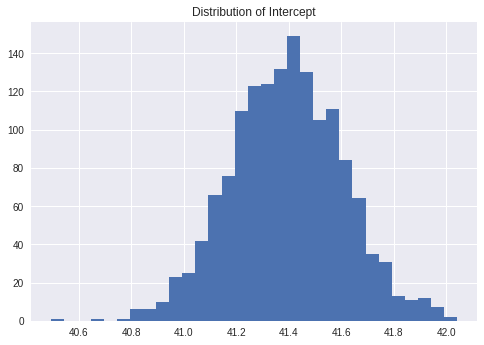

In [0]:
# Histogram of constant (B0)
plt.hist(beta0, bins='auto')  
plt.title("Distribution of Intercept")
plt.show()

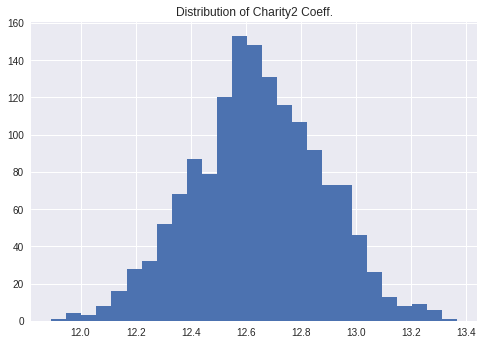

In [0]:
# Histogram of charity1 coeff (B1)
plt.hist(beta1, bins='auto')  
plt.title("Distribution of Charity2 Coeff.")
plt.show()

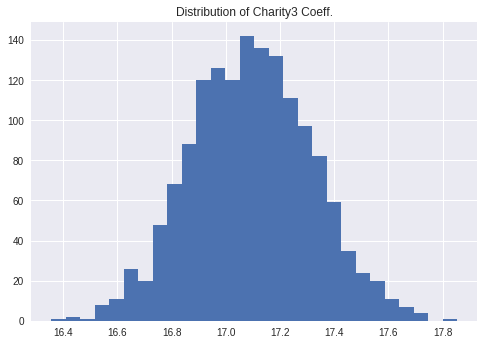

In [0]:
# Histogram of charity2 coeff (B2)
plt.hist(beta2, bins='auto')  
plt.title("Distribution of Charity3 Coeff.")
plt.show()

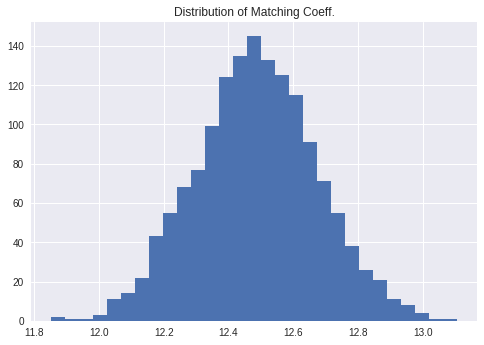

In [0]:
# Histogram of matching coeff (B3)
plt.hist(beta3, bins='auto')  
plt.title("Distribution of Matching Coeff.")
plt.show()

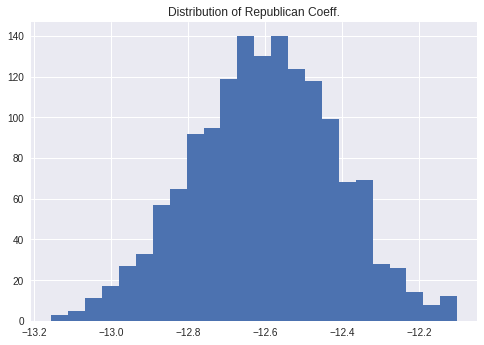

In [0]:
# Histogram of matching coeff (B4)
plt.hist(beta4, bins='auto')  
plt.title("Distribution of Republican Coeff.")
plt.show()

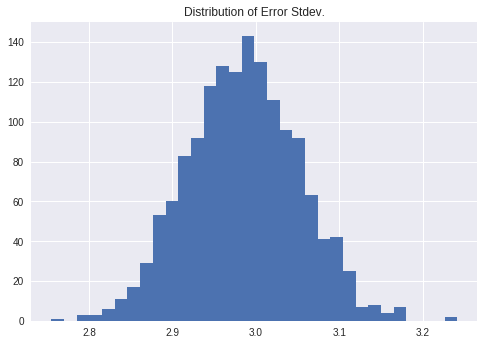

In [0]:
# Histogram of matching standard deviations
plt.hist(np.sqrt(precesion_draw), bins='auto')  
plt.title("Distribution of Error Stdev.")
plt.show()

## Double check with pymc3 

Altough this notebook does not rely on pymc3, let us check whether the results above are sensible. 

The pymc3 results differ from what is implemented above, but I believe the default priors for pymc3 are not the same as what was previously implemented. You will notice the variance in the pymc3 distributions is larger. 

In [0]:
import pymc3 as pm

# Regression model
formula = "donation ~ charity2 + charity3 + matching + republicanparticipant"

# Length of chain
n_chain_draws = 2000

In [0]:
# Function for drawing points from pymc3
def pymc3_post_draw(n_chain, df):
  
  # Context for the model
  with pm.Model() as normal_model:
    
      # The prior for the data likelihood is a Normal Distribution
      family = pm.glm.families.Normal()

      # Creating the model requires a formula and data (and optionally a family)
      pm.GLM.from_formula(formula, data = df)

      # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
      normal_trace = pm.sample(draws=n_chain, chains = 2, tune = 1000, njobs=-1)
  
  # Random index on second half of chain
  draw_index = np.random.randint(n_chain/2,n_chain)
  
  # List keys
  keys_list = sorted(normal_trace[draw_index].keys())
  
  # Draw from posterior
  post_draw = [normal_trace[draw_index][keys_list[i]] for i in range(0,len(keys_list)-1)]
  
  return [post_draw,normal_trace]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, republicanparticipant, matching, charity3[T.True], charity2[T.True], Intercept]
100%|██████████| 2000/2000 [00:05<00:00, 368.18it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6b29bd090>,
      dtype=object)

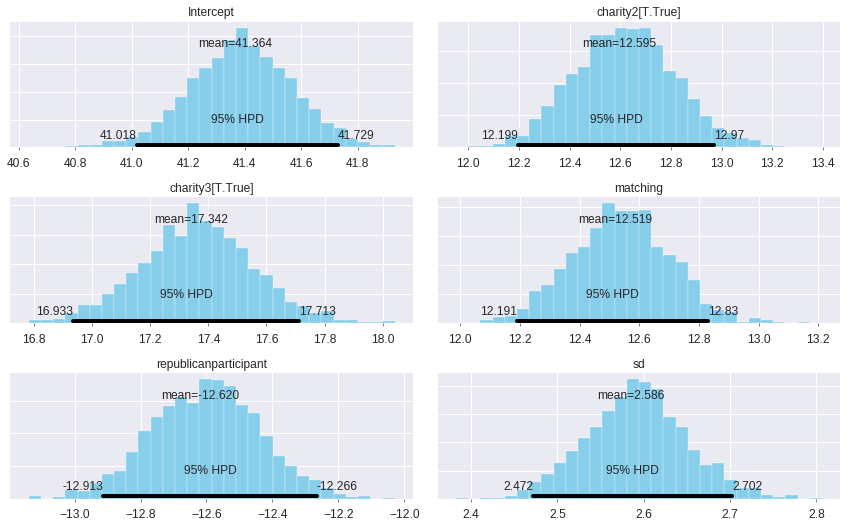

In [11]:
# Plot distribution of coeffecients from pymc3
normal_trace = pymc3_post_draw(1000, df)[1]
pm.plot_posterior(normal_trace)

In [12]:
# Draw from pymc3 posterior
# This can be used later in the notebook if needed
pymc3_post_draw(1000, df)[0]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, republicanparticipant, matching, charity3[T.True], charity2[T.True], Intercept]
100%|██████████| 2000/2000 [00:05<00:00, 385.53it/s]


[41.13462250727079,
 12.992153394165063,
 17.394409888353753,
 12.798363725345634,
 -12.738247113180876,
 2.622449915555744]

## Thompson Sampling with Bayesian Linear Regression

### Intuition

Suppose the data is collected in several batches over time, and each batch has k users. For each user within batch:


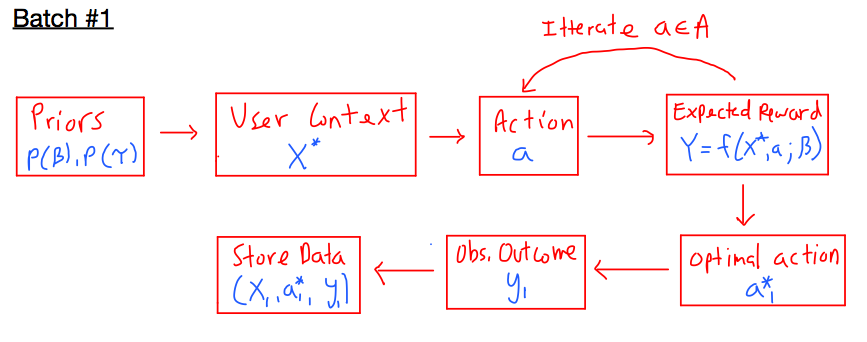

In [0]:
# Import figures
from IPython.display import Image, display
display(Image(filename='Batch1.png', embed=True))

Note observed outcome generated by true linear regression model. Whereas the expected reward given by hypothesized linear regression model. No updating of priors in batch #1. The priors govern the expected reward function.

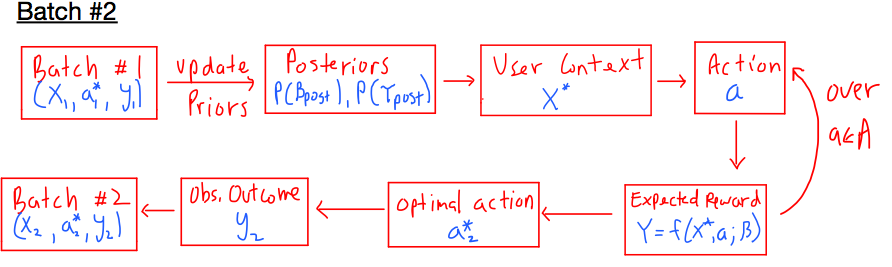

In [0]:
# Batch 2 intuition
display(Image(filename='Batch2.png', embed=True))

For batch 3 and onwards we follow the same steps as above, the prior is always updated using data from the previous batch.

### Sketch of Algorithm
Note that the true model is $E(Y|X^*) = X^*\beta$, and the hypothesized model is $E(Y|X) = X\alpha.$ Regret is computed as the optimal reward under the true model minus the optimal reward under hypothesized model $R(Y|X, X^*).$

1. Define reward function (based on hypothesized model) $E(Y|X) = X\alpha$  and distributions for priors $\pi(\alpha)$

Loop over all batches $j = 1, 2, \ldots, J$

2. Sample from priors (note these are updated based on all prior batch data): $\alpha_{j} | (X,a,Y) \sim  \pi(\alpha_{j})$

  Loop over all users in batch $i = 1, \ldots, N_{j}$

  3. Observe user context(s) $X_{ij}$

  4. Compute optimal action: $a_{j} = argmax_{a} E(Y_{i}|X_{ij})$ and $a_{j}^{*} = argmax_{a} E(Y_{i}|X_{ij}^{*})$

  5. Observe reward $Y_{ij}$ after assigning $a_{j}$ (generated from true model)
  
  6. Compute regret $R_{ij} = R(Y|X, X^*) = E(Y_{i}|X_{ij}^*;a_{j}^{*}) - E(Y_{i}|X_{ij};a_{j})$

6. Given batch $k$ of data, update prior distribution using $((X_{ij}, a_{j},  Y_{ij},R_{ij})_{j=1}^{N_{i}})_{j=1}^{k}$

### Charitable Giving Application

Suppose the hypothsized model is: $$Y = \alpha_{0} + \alpha_{1}Charity2 + \alpha_{2}Charity3 + \alpha_{3}Matching + \alpha_{4}Republican + \epsilon$$

Whereas the true model is: $$Y = \beta_{0} + \beta_{1}Charity2 + \beta_{2}Charity3 + \beta_{3}Matching + \beta_{4}Republican + \beta_{5}Matching \times Charity2 + \beta_{6}Matching \times Charity3 + \beta_{7}Matching \times Republican + \epsilon $$
with $\beta_{0} = 40, \beta_{1} = 10, \beta_{2} = 20, \beta_{3} = 15, \beta_{4} = -10, \beta_{5} = -5, \beta_{6} = 5,$ and  $\beta_{7} = -5.$

### Adjusting this notebook
If you would like to implement your own hypothesized and true models, you need to adjust the following components of the code:

1. gen_outcome(A, R, Error) 
    - Function for generating outcome from true model
2. optimal_reward_list(action_set, beta_thompson, context) 
    - Function for computing reward list over entire action set
3. Environment (initializing priors and action set)
4. Thompson sampling algorithm (design vector)

#### Functions for True and Hypothesized Model




In [0]:
### Adjust: true model is specified here ###
# True model (we will hard code this for now, make it generic later)
# A is the choosen action, for example A = [0, 0 , 1] is charity 1 and matching
# R is a binary contextual variable, R = 1 is republican, R = 0 is democratic
def gen_outcome(A, R, Error):
  
  # Actions (C2, C3 are charities, and M is matching)
  C2 = A[0]
  C3 = A[1]
  M = A[2]
  
  # Include error term (realized outcome)
  if Error == True:
  
    # Y = X*beta + epsilon (specify true model here)
    y_obs = 40 + 10*C2 + 20*C3 + 15*M -10*R -5*M*C2 + 5*M*C3 -5*M*R + nprnd.normal(scale=1, size=1)
    
    # Charity 2 and no matching is best
    # y_obs = 40 + 20*C2 + 10*C3 - 10*M -10*R + nprnd.normal(scale=1, size=1)

    # Matching has large negative returns for republicans
    #y_obs = 40 + 10*C2 + 20*C3 + 10*M -10*R -20*M*R + nprnd.normal(scale=1, size=1)

    return y_obs[0]
    
  # No error (expected outcome)
  else:
    
    # E(Y|X) = X*beta
    y_obs = 40 + 10*C2 + 20*C3 + 15*M -10*R -5*M*C2 + 5*M*C3 -5*M*R
    
    # Charity 2 and no matching is best
    # y_obs = 40 + 20*C2 + 10*C3 - 10*M -10*R

    # Matching has large negative returns for republicans
    #y_obs = 40 + 10*C2 + 20*C3 + 10*M -10*R -20*M*R
    
    return y_obs  

In [0]:
# Hypothesized model
# Beta is coeffecients from hypothesized model, X is the design vector
# X = [1, actions, context] and beta is from thompson sampling
def reward_hypo(beta, X):
  
  # E(Y|X) reward from hypothesized model (no noise)
  y_exp = np.dot(X, beta)
  
  return y_exp

In [0]:
# Pick optimal action given action set and hypothesized model
def optimal_reward_list(action_set, beta_thompson, context):
  
  # Number of possible actions
  n_actions = len(action_set)
  
  # Expected reward given action and max expected reward per batch
  reward = []
  reward_true = []

  ## Select optimal action
  for a in range(0,n_actions):
    
      # Expected reward according to true model (used for regret)
      true_reward_action = gen_outcome(action_set[a], context, False)
      reward_true = np.append(reward_true, true_reward_action)
      
      ### Adjust: Design vector for hypothesized model ###
      ## Hypothesized model assigned here
      # Context and action X = [1, actions, context]
      X_hypo = np.transpose(np.append(np.append(1,action_set[a]), context))
      # X_hypo = np.transpose(np.append(np.append(np.append(1,action_set[a]), context), action_set[a][2]*context))

      # Expected reward (from hypothesized model)
      reward_action = reward_hypo(beta_thompson, X_hypo)
      reward = np.append(reward, reward_action)
  
  return [reward,reward_true]

#### Setup Environment

In [0]:
# Environment setup
n_total = 1000
n_batches = 100
n_perbatch = n_total/n_batches

### Adjust: number of parameters in hypothesized model ###
# Design matrix (from generated data)
# ones = np.ones(len(outcome))
#design_multiple = np.column_stack((ones, charity2, charity3, matching, republican))
#design_multiple = np.column_stack((ones, charity2, charity3, matching, republican, matching*republican))
#n_param_hypo = design_multiple.shape[1]
n_param_hypo = 5
n_user = n_perbatch

# Keep track of batch
start_batch = 1
end_batch = n_perbatch

# Expected reward given action and max expected reward per batch
#reward = []
optimal_reward = []
optimal_reward_true = []
regret_list = []

# Save data over time
obs_outcome = []
obs_context = []
optimal_action = []
mean_batch_reward = []
mean_batch_regret = []

# I generate two rows of 0s, because it easy to append on this matrix. 
# Ideally we would want to a empty matrix that can be appended to in the loop
X_design = np.append([np.zeros(n_param_hypo)], [np.zeros(n_param_hypo)], axis = 0)

# Context vector
Republican = np.array(df["republicanparticipant"])


### Adjust: Set priors for hypothesized model ###
# Prior parameters (mean, covariance, shape, and scale)
# Note mean parameter contains prior assumptions about the coeffecients
#mu_pre = np.zeros(n_param_hypo)
# Assume chairity2 = charity3 > charity3 and matching > 0 and republican < 0
mu_pre = np.array([20,10,10,5,-5]) 
# mu_pre = np.array([30,10,10,-5,-5]) 
# mu_pre = np.array([30,10,10,5,-5,-10])
V_pre = np.eye(n_param_hypo)
a1_pre = 2
a2_pre = 2
y_pre = np.zeros(n_perbatch)
X_pre = np.zeros([n_perbatch,n_param_hypo])

### Adjust: Action set for hypothesized model ###
# Set of all actions (three charities and binary matching)
# The set of actions depends of the hypothesized model
# For example [0,1,0] is charity2 and no matching
actions = [np.array([0,0,0]), np.array([1, 0,0]), np.array([0, 1,0]), np.array([0,0,1]), np.array([1, 0,1]), np.array([0, 1,1])]

# Number of actions
n_actions = len(actions)

#### Thompson Sampling Algorithm 

In [0]:
## Thompson sampling with bayesian linear regression 

# Loop over batches
for batch in range(1,n_batches+1):
  
  # Draw priors for hypothesized model 
  # Priors are updated using data from previous batches
  thompson_sample = posteriors(y_pre, X_pre, mu_pre, V_pre, a1_pre, a2_pre)
  
  # First index has [betas, s^2, a1, a2]
  prior_thompson = thompson_sample[0]
  
  # Save covariance matrix of betas
  beta_covariance = thompson_sample[1]
  
  # Beta coeffecient priors
  beta_thompson = prior_thompson[0:n_param_hypo]
  
  # Shape and scale parameters
  scale_thompson = prior_thompson[-1]
  shape_thompson = prior_thompson[-2]
  
  ## Loop over users within batch
  for user in range(start_batch, end_batch+1):
    
    # Get user context
    context = Republican[user-1]
    
    # Optimal action rewards list
    # Used to pick optimal action for user
    reward_hypo_true = optimal_reward_list(actions, beta_thompson, context)
    reward = reward_hypo_true[0]
    reward_true = reward_hypo_true[1]
    
    ## Save (X, a, Y) for user (append to previous data)
    
    # Save Optimal reward (hypthothesized model)
    max_reward = np.max(reward)
    optimal_reward = np.append(optimal_reward, max_reward)
    
    # Save optimal reward (true model)
    max_reward_true = np.max(reward_true)
    optimal_reward_true = np.append(optimal_reward_true, max_reward_true)
    
    # Compute regret 
    regret = max_reward_true - max_reward
    regret_list = np.append(regret_list, regret)
    
    # Save context
    obs_context = np.append(obs_context, context)
    
    # Save action that maximizes reward
    best_action = np.argmax(reward)
    optimal_action = np.append(optimal_action, best_action)

    # Generate data given optimal action (from true model)
    true_outcome = gen_outcome(actions[best_action], context, True)
    obs_outcome = np.append(obs_outcome, true_outcome)
    
    
    ### Adjust: design matrix for hypothesized model ###
    # Save design [1, actions, contexts]
    # Append data from each user a row in the design matrix
    X_user = np.append(np.append(1, actions[best_action]), context)
    #X_user = np.append(np.append(np.append(1, actions[best_action]), context), context*actions[best_action][2])
    X_design = np.append(X_design, [X_user], axis=0)
    
    # Reset variables for new user
    # reward = []

  # Track mean batch reward
  mean_reward = np.mean(optimal_reward)
  mean_batch_reward = np.append(mean_batch_reward, mean_reward)
  
  # Track mean batch regret
  mean_regret = np.mean(regret)
  mean_batch_regret = np.append(mean_batch_regret, mean_regret)

  # Reset variables for new batch
  optimal_reward = []
  optimal_reward_true = []
  regret_list = []

  ## End of Batch 
 
  # Update priors using (X,a,y, beta, V, a1, a2)
  # Thompson sample of priors is used as an input to get posteriors
  mu_pre = beta_thompson
  V_pre = beta_covariance
  a1_pre = shape_thompson
  a2_pre = scale_thompson
  y_pre = obs_outcome[(start_batch-1):end_batch]
  # Throw out first two rows (all 0s)
  X_pre = X_design[(start_batch+1):(end_batch+2)]
  
  # Less effecient is to fit the entire bayesian linear reg again:
  # mu_pre = np.zeros(n_param_hypo)
  # V_pre = np.eye(n_param_hypo)
  #a1_pre = 2
  #a2_pre = 2
  # dim(y) = n_user x 1 and dim(X) = n_user x k
  # y_pre = obs_outcome
  # X_pre = X_design[2:(n_user+2)]

  # Save data from batch to update prior
  # Increment Start and end of batch users
  start_batch += n_perbatch
  end_batch += n_perbatch
  n_user += n_perbatch

#### Random Policy

In [0]:
# Random Policy (actions are randomly assigned to each user)
def random_policy(n_total, n_perbatch, action_set, context):
  
  # Size of action set
  n_actions = len(action_set)
  
  # Save outcomes per batch
  outcome_list = []
  mean_outcome_batch = []
  
  # Save actions over time
  action_user = []
  
  # Loop over all users
  for user in range(0, n_total):
    
    # Randomly assign action
    action_index = np.random.randint(0,n_actions)
    rand_action = action_set[action_index]
    
    # Compute outcome (from true model) using action and context
    outcome = gen_outcome(rand_action, context[user], True)
    
    # Update outcomes list
    outcome_list = np.append(outcome_list, outcome)
    
    # Update actions list
    action_user = np.append(action_user,action_index+1)
    
    # Compute batch mean reward at multiple of n_perbatch
    if ((user+1) % n_perbatch) == 0:
      
      # Save mean outcome per batch
      mean_outcome_batch = np.append(mean_outcome_batch, np.mean(outcome_list))
      
      # Reset outcomes list
      outcome_list = []   
    
  return [mean_outcome_batch,action_user]

### Plot Reward and Regret

Let us plot the outcome under contextual bandits and random policy.

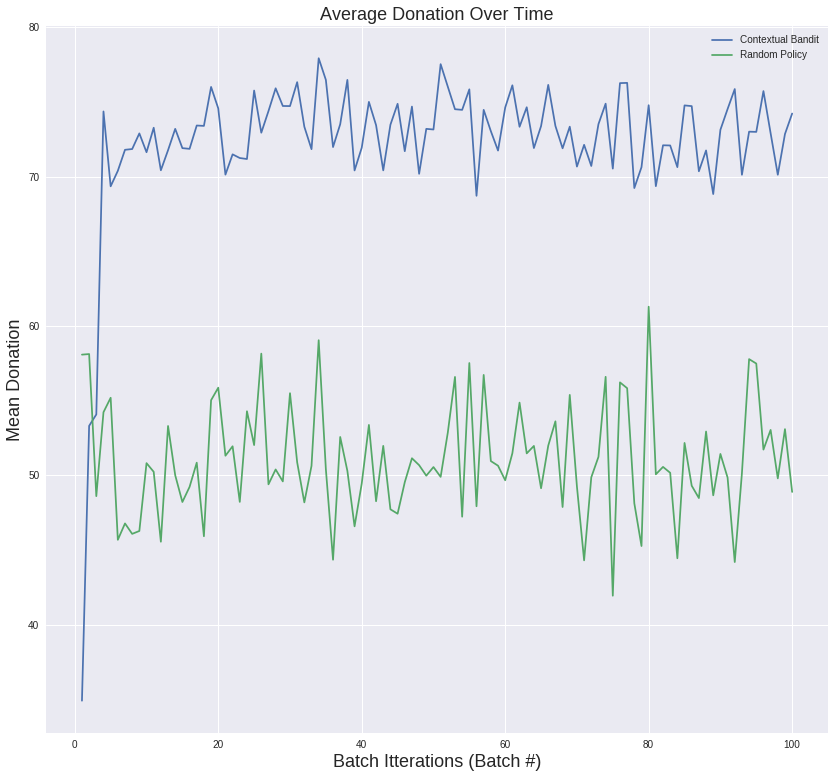

In [19]:
# Change figure size
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14,13]

# Batch Itterations
BatchItter = range(1,n_batches+1)

# Random policy (first entry is rewards, second entry is corresponding actions)
rand_policy_reward = random_policy(n_total, n_perbatch, actions, obs_context)

# Plot cummulatative reward
# Ask joseph if observed outcome or expected outcome on plot
context_bandit = plt.plot(BatchItter, mean_batch_reward, label = "Contextual Bandit")
rand_policy = plt.plot(BatchItter,rand_policy_reward[0], label = "Random Policy")

# Legend and labels
#plt.legend([context_bandit], ['Contextual Bandit'])
#plt.legend([rand_policy], ['Random Policy'])
plt.legend(loc='upper right')
plt.xlabel('Batch Itterations (Batch #)', fontsize = 18)
plt.ylabel('Mean Donation', fontsize = 18)
plt.title('Average Donation Over Time', fontsize = 18)
plt.show()

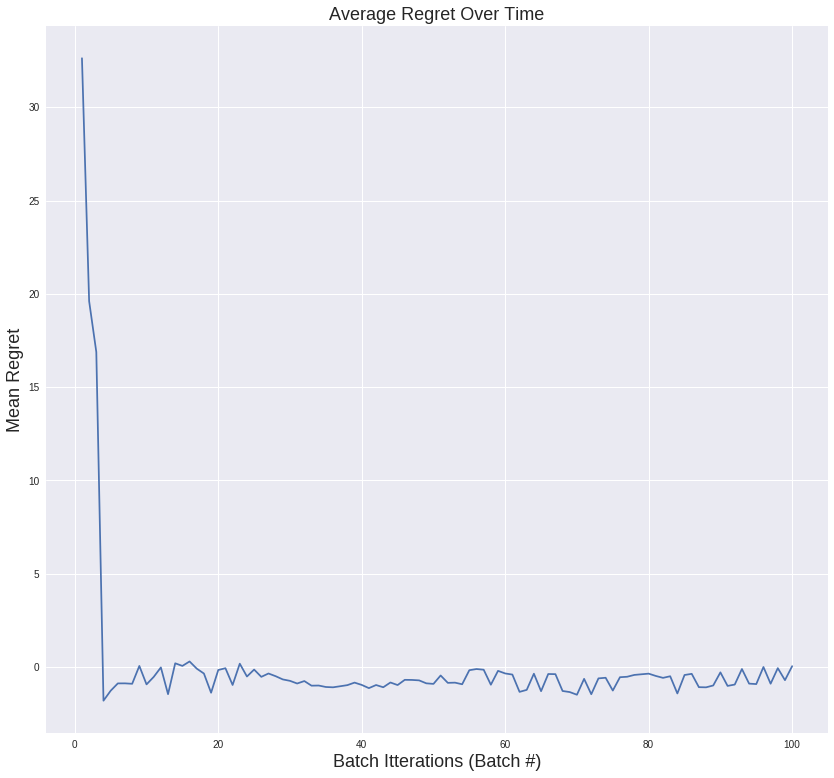

In [20]:
# Plot mean regret against batch itteration
plt.plot(BatchItter, mean_batch_regret)
plt.xlabel('Batch Itterations (Batch #)', fontsize = 18)
plt.ylabel('Mean Regret', fontsize = 18)
plt.title('Average Regret Over Time', fontsize = 18)
plt.show()

## Simulation Excercises 
Now we will go through a bunch of simulations and check whether the contextual bandit can recover the optimal policy under differ scenerios.


Recall that the possibilities for the actions are: \\
Action 0: (charity1, no matching) \\
Action 1: (charity2, no matching) \\
Action 2: (charity3, no matching) \\
Action 3: (charity1,  matching) \\
Action 4: (charity2, matching) \\
Action 5: (charity3, matching) 



## No Personalization (Policy not depend on context)

### Action 5 = (Charity3, Matching) is optimal

True Model: $E(Y|C2, C3, M, R) = 40 + 10C2 + 20C3 + 15M -10R -5M \times C2 + 5M \times C3 -5M \times R$

Hypothesized Model: $E(Y|C2,C3,M,R) = \alpha_{0} + \alpha_{1}Charity2 + \alpha_{2}Charity3 + \alpha_{3}Matching + \alpha_{4}Republican$

Initial coeffecient mean for prior: $\beta_{prior} = (20,10,10,5,-5).$

For the hypothesized model, we expect action 5 to the optimal policy for all users as charity3 and matching on average will be associated with the largest donations. 

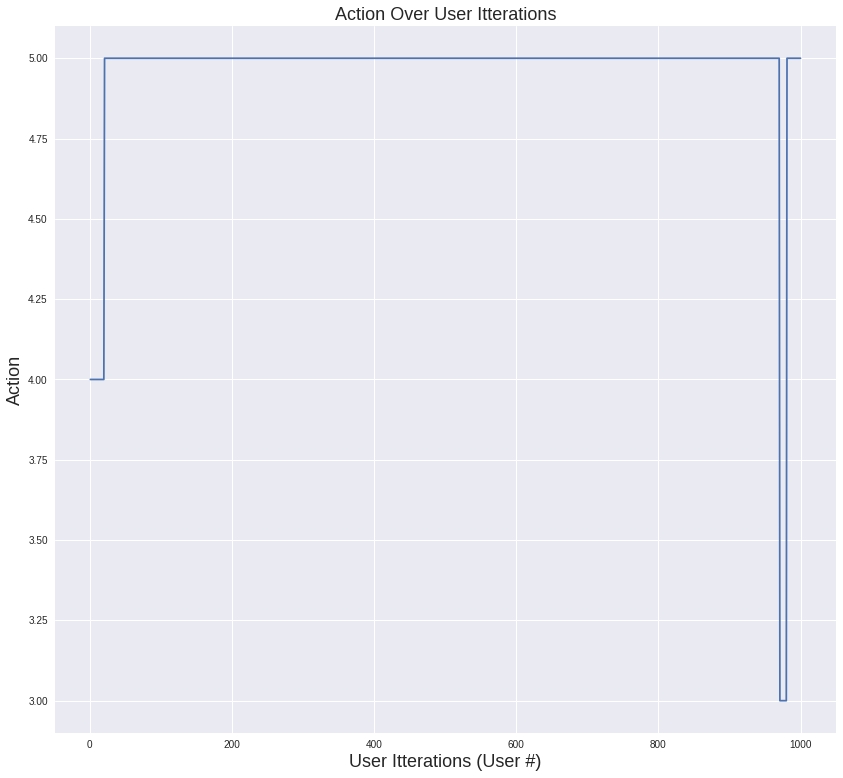

In [21]:
# User Itterations
UserItter = range(1,n_total+1)

# Plot cummulatative reward
plt.plot(UserItter, optimal_action)
plt.xlabel('User Itterations (User #)', fontsize = 18)
plt.ylabel('Action', fontsize = 18)
plt.title('Action Over User Itterations', fontsize = 18)
plt.show()

In [22]:
# Number of times action 4 is choosen
n_action3 = sum(optimal_action == 3)
print('Number of action 3: %s' %n_action3)

# Number of times action 4 is choosen
n_action4 = sum(optimal_action == 4)
print('Number of action 4: %s' %n_action4)

# Number of times action 5 is choosen
n_action5 = sum(optimal_action == 5)
print('Number of action 5: %s' %n_action5)

Number of action 3: 10
Number of action 4: 20
Number of action 5: 970


Now let us change the true model so that Action 1 is optimal.  This change can be implemented using the gen_outcome function above. 

### Action 1 = (Charity2, No Matching) is optimal

True Model: $E(Y|C2, C3, M, R) = 40 + 20C2 + 10C3 - 10M -10R$

Hypothesized Model: $E(Y|C2,C3,M,R) = \alpha_{0} + \alpha_{1}Charity2 + \alpha_{2}Charity3 + \alpha_{3}Matching + \alpha_{4}Republican$

Initial coeffecient mean for prior: $\beta_{prior} = (30,10,10,5,-5).$

As can be seen by the policy functio below, the contextual bandit is able to assign most of the users to the optimal action of 1. 

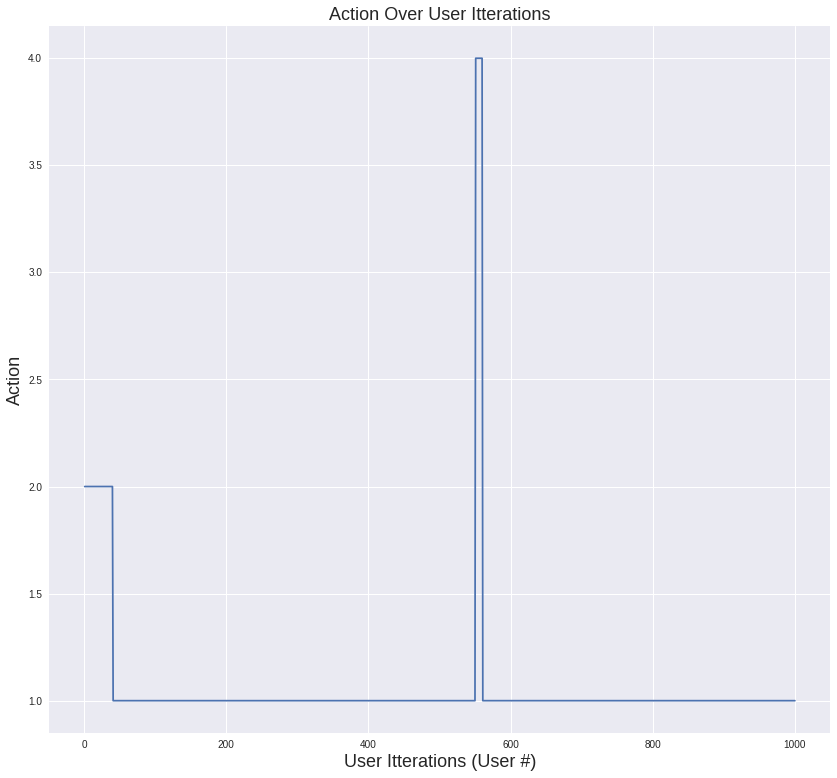

In [0]:
# User Itterations
UserItter = range(1,n_total+1)

# Plot cummulatative reward
plt.plot(UserItter, optimal_action)
plt.xlabel('User Itterations (User #)', fontsize = 18)
plt.ylabel('Action', fontsize = 18)
plt.title('Action Over User Itterations', fontsize = 18)
plt.show()

## Personalization (Policy depends on context)

### Action 5 = (Charity3, Matching) optimal for democrats and (Charity3, No Matching) and Action 2 = (Charity3, Matching) optimal for republicans

True model: $E(Y|C2, C3, M, R) =  40 + 10C2 + 20C3 + 10M -10R -20M \times R$

Hypothesized Model: $E(Y|C2,C3,M,R) = \alpha_{0} + \alpha_{1}Charity2 + \alpha_{2}Charity3 + \alpha_{3}Matching + \alpha_{4}Republican$

Initial coeffecient mean for prior: $\beta_{prior} = (30,10,10,5,-5).$

Note that since the hypothesized model does not allow for cross-over effects, it is not able to recover the optimal policy as can be seen below. 

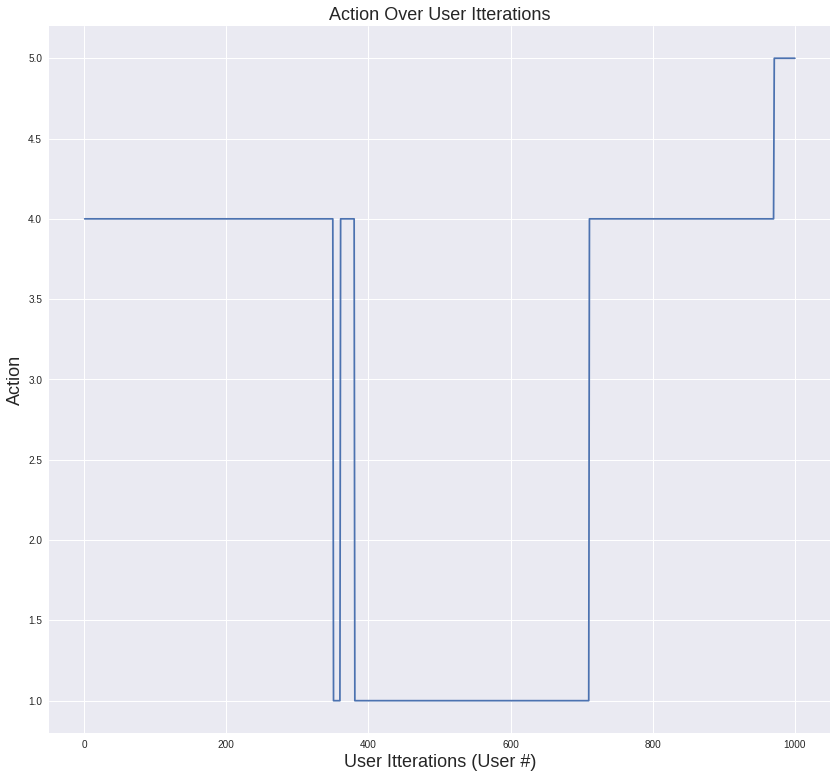

In [0]:
# User Itterations
UserItter = range(1,n_total+1)

# Plot cummulatative reward
plt.plot(UserItter, optimal_action)
plt.xlabel('User Itterations (User #)', fontsize = 18)
plt.ylabel('Action', fontsize = 18)
plt.title('Action Over User Itterations', fontsize = 18)
plt.show()

Let us now use an hypothesized model that allows for an interaction between matching and political affliation. 

True model: $E(Y|C2, C3, M, R) =  40 + 10C2 + 20C3 + 10M -10R -20M \times R$

Hypothesized Model: $E(Y|C2,C3,M,R) = \alpha_{0} + \alpha_{1}Charity2 + \alpha_{2}Charity3 + \alpha_{3}Matching + \alpha_{4}Republican + \alpha_{5}Republican \times Matching$

Initial coeffecient mean for prior: $\beta_{prior} = (30,10,10,5,-5,-10).$


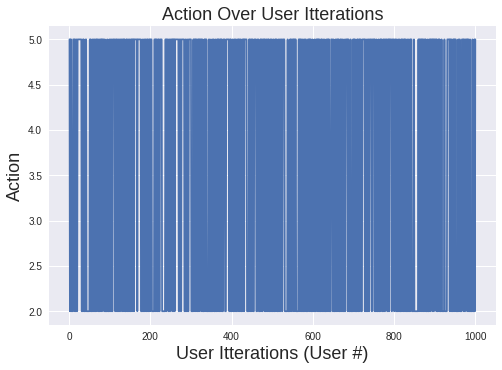

In [0]:
# User Itterations
UserItter = range(1,n_total+1)

# Plot cummulatative reward
plt.plot(UserItter, optimal_action)
plt.xlabel('User Itterations (User #)', fontsize = 18)
plt.ylabel('Action', fontsize = 18)
plt.title('Action Over User Itterations', fontsize = 18)
plt.show()

In [0]:
# Number of times action 2 is choosen
n_action2 = sum(optimal_action == 2)
print('Number of action 2: %s' %n_action2)

# Number of times action 5 is choosen
n_action5 = sum(optimal_action == 5)
print('Number of action 5: %s' %n_action5)

Number of action 2: 531
Number of action 5: 469


Let us plot the policy function for democrats and republicans seperately. We expect most democrats to be assigned action 5 and most republicans to be given action 2.

#### Optimal policy for democrats


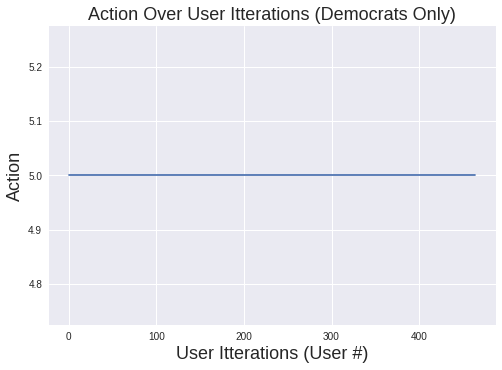

In [0]:
# User Itterations
UserItter = range(1,sum(Republican == 0)+1)

# Plot cummulatative reward (republicans only)
plt.plot(UserItter, optimal_action[Republican == 0])
plt.xlabel('User Itterations (User #)', fontsize = 18)
plt.ylabel('Action', fontsize = 18)
plt.title('Action Over User Itterations (Democrats Only)', fontsize = 18)
plt.show()

#### Optimal policy for republicans


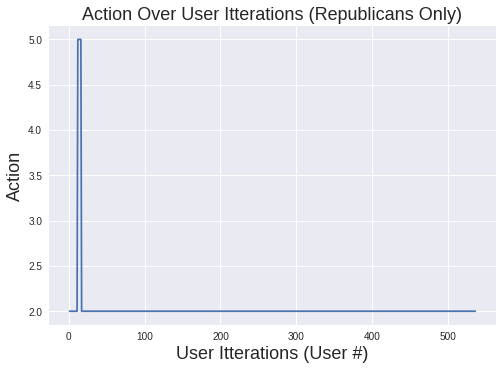

In [0]:
# User Itterations
UserItter = range(1,sum(Republican == 1)+1)

# Plot cummulatative reward (republicans only)
plt.plot(UserItter, optimal_action[Republican == 1])
plt.xlabel('User Itterations (User #)', fontsize = 18)
plt.ylabel('Action', fontsize = 18)
plt.title('Action Over User Itterations (Republicans Only)', fontsize = 18)
plt.show()